In [92]:
import pandas as pd
import numpy as np
import json
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [74]:
comments_flatearth = pd.read_csv("./data/comments_flatearth.csv")
comments_chemtrails = pd.read_csv("./data/comments_chemtrail.csv")
comments_newchron = pd.read_csv("./data/comments_newchron.csv")

stances_flatearth = pd.read_csv("./data/gephi_flatearth_stances/nodes.csv")
stances_chemtrails = pd.read_csv("./data/gephi_chem_stances/nodes.csv")
stances_newchron = pd.read_csv("./data/gephi_newchron_stances/nodes.csv")

all_comments = [comments_flatearth, comments_chemtrails, comments_newchron]
all_stances = [stances_flatearth, stances_chemtrails, stances_newchron]
theory_names = ["Плоская Земля", "Химтрейлы", "Новая хронология"]

In [85]:
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

palette = {
    "поддерживает": "#1f77b4",
    "не поддерживает": "#d62728",
    "невозможно определить": "#7f7f7f"
}

sns.set_theme(
    style="whitegrid",
    font_scale=1.25,
    rc={
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "axes.unicode_minus": False
    }
)
mpl.rcParams.update({
    "axes.titlesize":   15,
    "axes.labelsize":   14,
    "legend.fontsize":  13,
    "xtick.labelsize":  11,
    "ytick.labelsize":  11,
    "figure.titlesize": 17
})


mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"]
})


patches = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

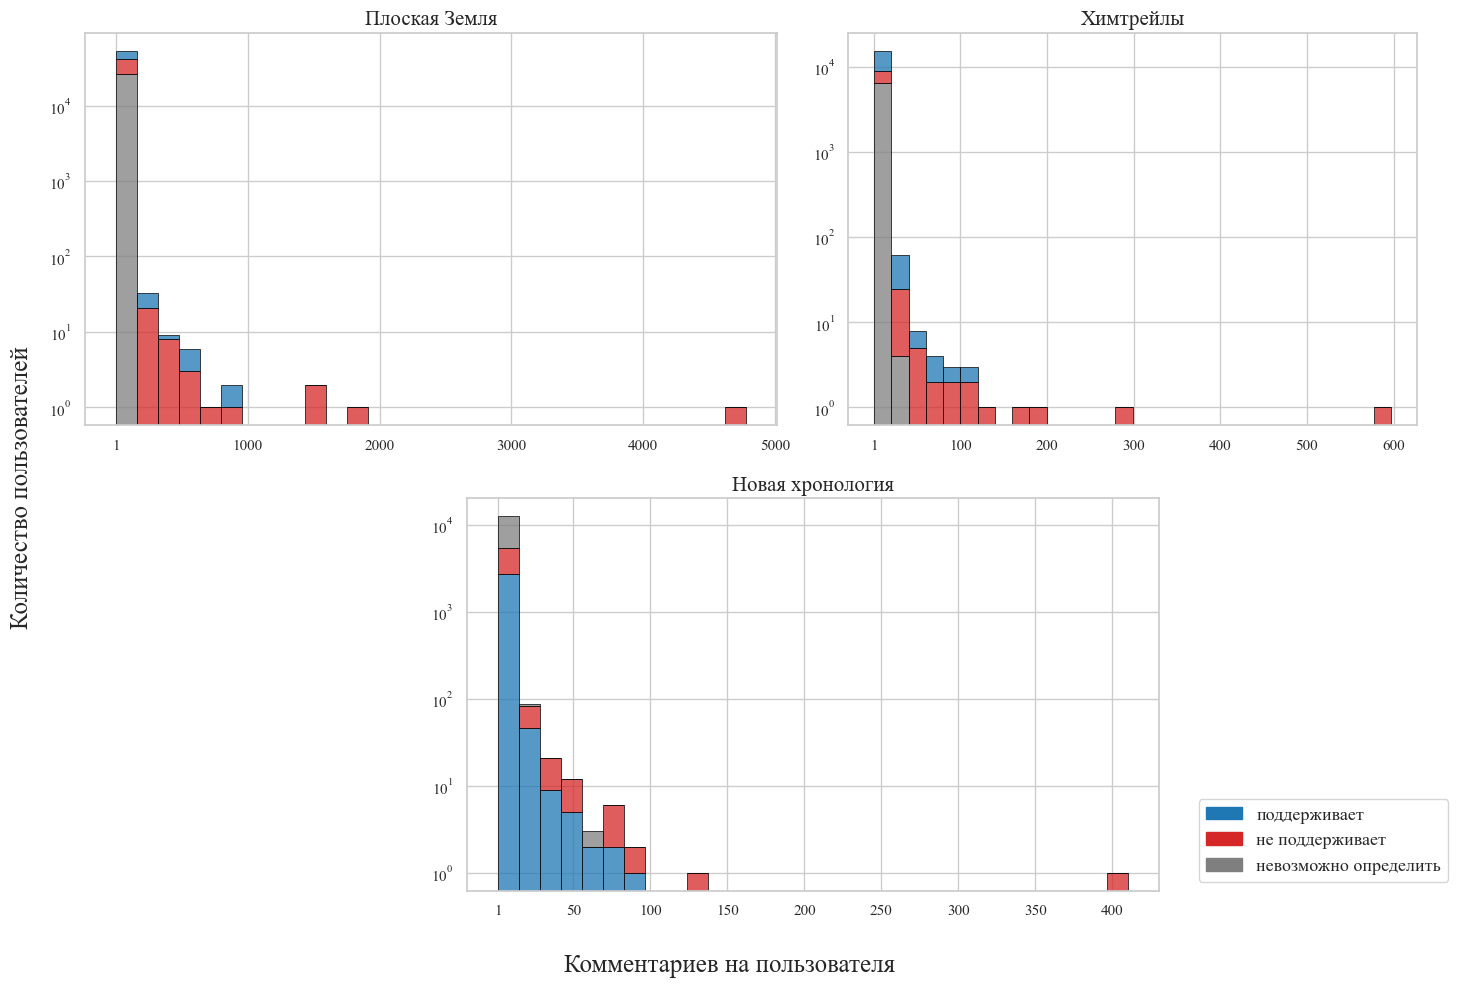

In [86]:
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(
    2, 4,
    height_ratios=[1, 1],
    width_ratios=[1, 1, 1, 0.6],
    figure=fig
)

ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[1, 1:3])

axes = [ax1, ax2, ax3]

legend_ax = fig.add_subplot(gs[1, 3])
legend_ax.axis("off")

for i, (comments, stances) in enumerate(zip(all_comments, all_stances)):
    counts = comments.groupby("authorDisplayName").size().reset_index(name="comment_count")
    merged = pd.merge(counts, stances, left_on="authorDisplayName", right_on="label")

    sns.histplot(
        data=merged,
        x="comment_count",
        hue="stance",
        bins=30,
        multiple="stack",
        palette=palette,
        edgecolor="black",
        linewidth=0.5,
        legend=False,
        ax=axes[i]
    )

    axes[i].set_yscale("log")
    axes[i].set_title(theory_names[i])
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    xt = axes[i].get_xticks()
    axes[i].set_xticks([1] + list(xt[2:-1]))

fig.supxlabel("Комментариев на пользователя")
fig.supylabel("Количество пользователей")

legend_ax.legend(handles=patches, loc="lower center")

plt.tight_layout()
plt.show()

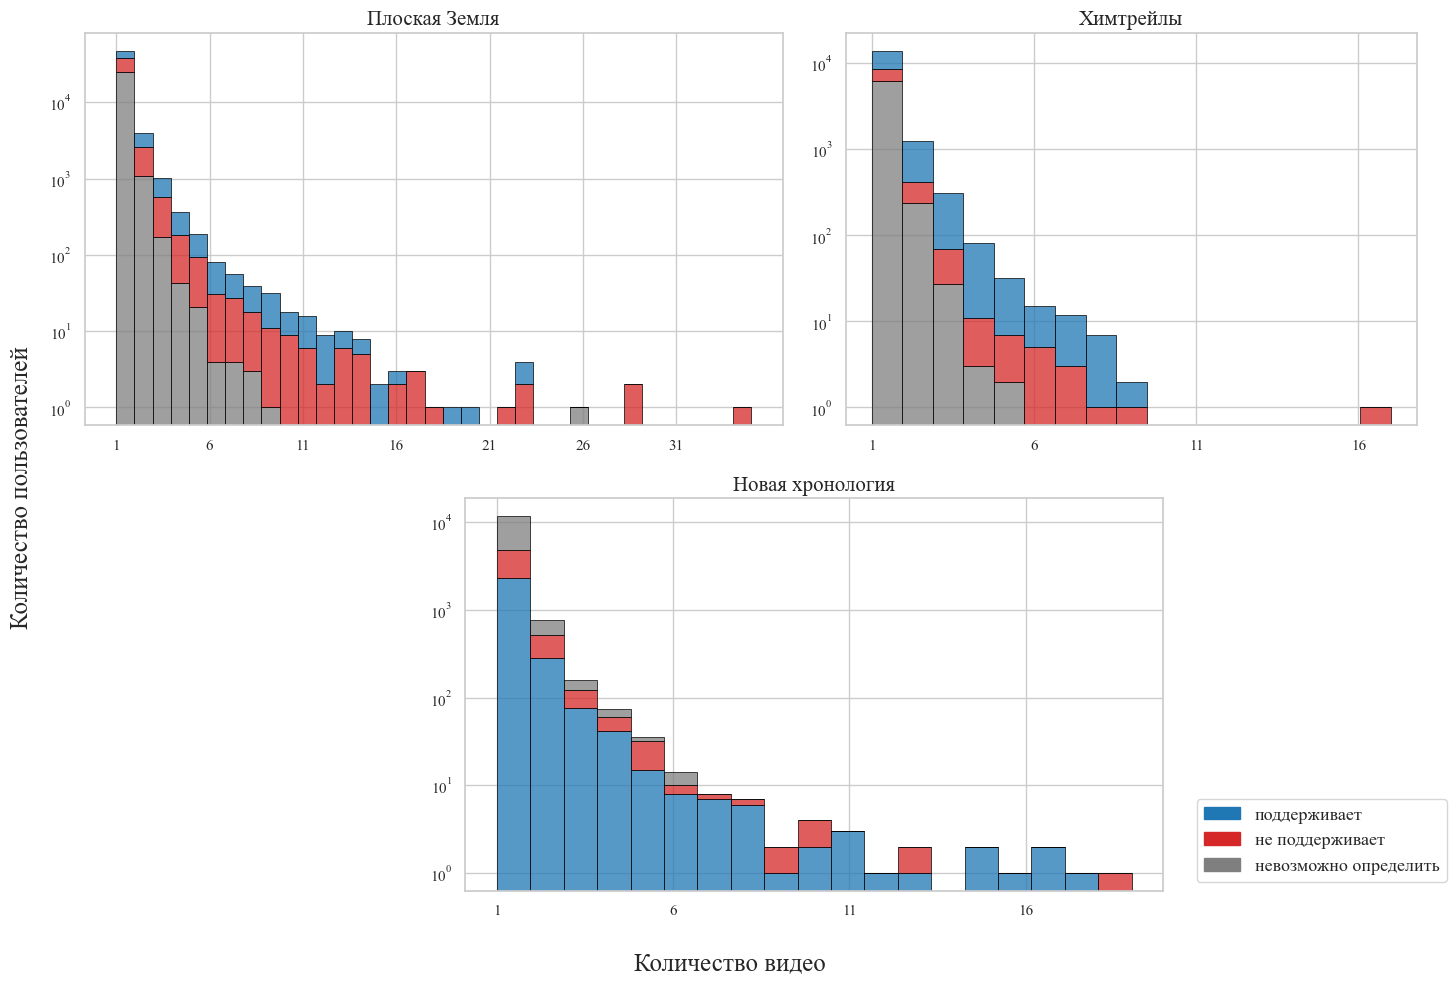

In [88]:
fig = plt.figure(figsize=(15, 10))
gs  = gridspec.GridSpec(
        2, 4,
        height_ratios=[1, 1],
        width_ratios=[1, 1, 1, 0.6],
        figure=fig
)

ax1, ax2, ax3 = (
    fig.add_subplot(gs[0, 0:2]),
    fig.add_subplot(gs[0, 2:4]),
    fig.add_subplot(gs[1, 1:3])
)
legend_ax = fig.add_subplot(gs[1, 3])
legend_ax.axis("off")

axes = [ax1, ax2, ax3]

for i, (comments, stances) in enumerate(zip(all_comments, all_stances)):
    vid_counts = (
        comments.groupby("authorDisplayName")["videoId"]
                .nunique()
                .reset_index(name="video_count")
    )
    merged = pd.merge(vid_counts, stances,
                      left_on="authorDisplayName", right_on="label")
    max_count = merged["video_count"].max()

    sns.histplot(
        data=merged,
        x="video_count",
        hue="stance",
        bins=max_count,
        multiple="stack",
        palette=palette,
        edgecolor="black",
        linewidth=0.5,
        legend=False,
        ax=axes[i]
    )

    axes[i].set_yscale("log")
    axes[i].set_title(theory_names[i])
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_xticks(range(1, max_count + 1, 5))

fig.supxlabel("Количество видео")
fig.supylabel("Количество пользователей")

legend_ax.legend(handles=patches, loc="lower center")

# fig.suptitle("Распределение пользователей по числу видео, которые они комментировали")

plt.tight_layout()
plt.show()

In [26]:
from functools import reduce

renamed = []
for i, df in enumerate(all_stances):
    renamed.append(df.rename(columns={"stance": f"stance_{i}"}))

merged = reduce(lambda left, right: pd.merge(left, right, on="label", how="outer"), renamed)

def not_all_equal(row):
    values = [row[col] for col in merged.columns if col.startswith("stance_")]
    values = [v if v != "невозможно определить" else None for v in values]
    values = [v for v in values if pd.notnull(v)]
    return len(set(values)) > 1 if values else False

merged["not_all_equal"] = merged.apply(not_all_equal, axis=1)
count = merged["not_all_equal"].sum()

print(f"Число пользователей с разными stance: {count}")

Число пользователей с разными stance: 283


In [36]:
for i in range(3):
    for j in range(3):
        if i == j:
            continue

        c1 = set(all_comments[i]["authorDisplayName"])
        c2 = set(all_comments[j]["authorDisplayName"])

        intersection_authors = c1.intersection(c2)
        intersection_df = pd.DataFrame({"authorDisplayName": list(intersection_authors)})

        stances_i = all_stances[i].rename(columns={"stance": "stance_i"})
        stances_j = all_stances[j].rename(columns={"stance": "stance_j"})

        merged = intersection_df \
            .merge(stances_i, left_on="authorDisplayName", right_on="label") \
            .merge(stances_j, left_on="authorDisplayName", right_on="label")

        merged = merged[
            (merged["stance_i"] != "невозможно определить") &
            (merged["stance_j"] != "невозможно определить")
        ]

        total = len(merged)
        supports = (merged["stance_i"] == "поддерживает").sum()
        opposes = (merged["stance_i"] == "не поддерживает").sum()

        print(f"Пересечение {theory_names[i]} (n={len(c1)}) и {theory_names[j]} (n={len(c2)}):")
        print(f"  Всего (определённых): {total}")
        print(f"  Поддерживает: {supports}")
        print(f"  Не поддерживает: {opposes}")
        print("-" * 40)

valid_authors_0 = set(all_stances[0].loc[all_stances[0]['stance'] != "невозможно определить", 'label'])
valid_authors_1 = set(all_stances[1].loc[all_stances[1]['stance'] != "невозможно определить", 'label'])
valid_authors_2 = set(all_stances[2].loc[all_stances[2]['stance'] != "невозможно определить", 'label'])

intersection_authors = valid_authors_0 & valid_authors_1 & valid_authors_2

print(f"Число пользователей, участвовавших во всех трёх дискуссиях и размеченных во всех них: {len(intersection_authors)}")

Пересечение Плоская земля (n=53308) и Химтрейлы (n=15771):
  Всего (определённых): 368
  Поддерживает: 207
  Не поддерживает: 161
----------------------------------------
Пересечение Плоская земля (n=53308) и Новая хронология (n=12813):
  Всего (определённых): 298
  Поддерживает: 133
  Не поддерживает: 165
----------------------------------------
Пересечение Химтрейлы (n=15771) и Плоская земля (n=53308):
  Всего (определённых): 368
  Поддерживает: 246
  Не поддерживает: 122
----------------------------------------
Пересечение Химтрейлы (n=15771) и Новая хронология (n=12813):
  Всего (определённых): 106
  Поддерживает: 80
  Не поддерживает: 26
----------------------------------------
Пересечение Новая хронология (n=12813) и Плоская земля (n=53308):
  Всего (определённых): 298
  Поддерживает: 139
  Не поддерживает: 159
----------------------------------------
Пересечение Новая хронология (n=12813) и Химтрейлы (n=15771):
  Всего (определённых): 106
  Поддерживает: 62
  Не поддерживает: 44

In [264]:
comments = pd.concat(all_comments)
comment_counts = comments.groupby(by="authorDisplayName").size().rename("count").reset_index()

stances = pd.concat(all_stances).drop_duplicates(["label"]).reset_index()

In [263]:
# участники всех трёх обсуждений
pd.merge(intersection, comment_counts, on="authorDisplayName")["count"].mean()

15.057142857142857

In [272]:
# все пользователи (по позициям)
pd.merge(comment_counts, stances, left_on="authorDisplayName", right_on="label").groupby("stance")["count"].mean()

stance
не поддерживает          4.347930
невозможно определить    1.503051
поддерживает             3.401644
Name: count, dtype: float64

In [273]:
# все пользователи
comment_counts["count"].mean()

2.6992300168041936

In [283]:
for i, (c, s) in enumerate(zip(all_comments, all_stances)):
    c_counts = c.groupby(by="authorDisplayName").size().rename("count").reset_index()
    print(theory_names[i])
    print(pd.merge(c_counts, stances, left_on="authorDisplayName", right_on="label").groupby("stance")["count"].mean(), "\n")

Плоская земля
stance
не поддерживает          4.721904
невозможно определить    1.481801
поддерживает             3.923915
Name: count, dtype: float64 

Химтрейлы
stance
не поддерживает          3.030245
невозможно определить    1.475539
поддерживает             2.459632
Name: count, dtype: float64 

Новая хронология
stance
не поддерживает          2.720139
невозможно определить    1.421624
поддерживает             2.580691
Name: count, dtype: float64 



In [106]:
nodes_flat = pd.read_csv("./data/gephi_flatearth_stances/nodes.csv")
edges_flat = pd.read_csv("./data/gephi_flatearth_stances/edges.csv")

nodes_chem = pd.read_csv("./data/gephi_chem_stances/nodes.csv")
edges_chem = pd.read_csv("./data/gephi_chem_stances/edges.csv")

nodes_newchron = pd.read_csv("./data/gephi_newchron_stances/nodes.csv")
edges_newchron = pd.read_csv("./data/gephi_newchron_stances/edges.csv")

In [107]:
def nx_graph(nodes_df, edges_df):
    nodes_df = nodes_df[nodes_df["nodeType"] == "user"]
    edges_df = edges_df.dropna()
    edges_df = pd.merge(edges_df, nodes_df, left_on="source", right_on="label")[["source", "target"]]
    edges_df = pd.merge(edges_df, nodes_df, left_on="target", right_on="label")[["source", "target"]]
    
    digraph = nx.from_pandas_edgelist(edges_df, create_using=nx.DiGraph)

    digraph.add_nodes_from((row["label"], dict({"stance": row["stance"]})) for ind, row in nodes_df.iterrows())
    
    return digraph

In [108]:
G_flat = nx_graph(nodes_flat, edges_flat)
G_chem = nx_graph(nodes_chem, edges_chem)
G_newchron = nx_graph(nodes_newchron, edges_newchron)

In [214]:
graphs = [G_flat, G_chem, G_newchron]

for G in graphs:
    defined_users = [n for n, attr in G.nodes(data=True) if attr["stance"] != "невозможно определить"]
    G_defined = G.subgraph(defined_users)
    print(len(G_defined.nodes), G_defined.number_of_edges())

26767 33241
9234 9625
5635 3983


In [110]:
def nx_ei(G, supporters=None, opposers=None):
    if supporters is None:
        supporters = [n for n, attr in G.nodes(data=True) if attr["stance"] == "поддерживает"]
    if opposers is None:
        opposers = [n for n, attr in G.nodes(data=True) if attr["stance"] == "не поддерживает"]

    I_supporters = G.subgraph(supporters).number_of_edges()
    I_opposers = G.subgraph(opposers).number_of_edges()

    E_supporters = len([e for e in nx.edge_boundary(G, supporters, opposers)])
    E_opposers = len([e for e in nx.edge_boundary(G, opposers, supporters)])
    
    EI_supporters = (E_supporters - I_supporters) / (E_supporters + I_supporters)
    EI_opposers = (E_opposers - I_opposers) / (E_opposers + I_opposers)
    
    return EI_supporters, EI_opposers

def ei_simulation(G, num_samples=100):
    in_degree_sequence = list(d for n, d in G.in_degree())
    out_degree_sequence = list(d for n, d in G.out_degree())
    supporters = [n for n, attr in G.nodes(data=True) if attr["stance"] == "поддерживает"]
    opposers = [n for n, attr in G.nodes(data=True) if attr["stance"] == "не поддерживает"]
    stances = nx.get_node_attributes(G, "stance")
    mapping = {i: n for i, n in enumerate(G.nodes)}

    ei_list = list()

    for i in range(num_samples):
        G_sim = nx.directed_configuration_model(in_degree_sequence, out_degree_sequence)
        G_sim = nx.relabel_nodes(G_sim, mapping)
        nx.set_node_attributes(G_sim, stances, name="stance")
        ei_list.append(nx_ei(G_sim, supporters, opposers))
    
    return ei_list

In [112]:
ei_flat_observed = nx_ei(G_flat)
ei_chem_observed = nx_ei(G_chem)
ei_newchron_observed = nx_ei(G_newchron)

In [10]:
ei_flat_list = ei_simulation(G_flat, 1000)

In [56]:
ei_chem_list = ei_simulation(G_chem, 1000)

In [57]:
ei_newchron_list = ei_simulation(G_newchron, 1000)

In [114]:
with open("./data/ei_simulations.txt", "r", encoding="utf8") as f:
    ei_lists = json.loads(f.read())

ei_lists = [ei_lists["Плоская земля"], ei_lists["Химтрейлы"], ei_lists["Новая хронология"]]
ei_observed = [ei_flat_observed, ei_chem_observed, ei_newchron_observed]

In [ ]:
ei_lists = [ei_flat_list, ei_chem_list, ei_newchron_list]
ei_observed = [ei_flat_observed, ei_chem_observed, ei_newchron_observed]

In [85]:
with open("./data/ei_simulations.txt", "w", encoding="utf8") as f:
    j = json.dumps({name: ei_list for (name, ei_list) in zip(theory_names, ei_lists)}, ensure_ascii=False)
    f.write(j)

In [116]:
percentiles = []

for ei_list, ei_ob, theory in zip(ei_lists, ei_observed, theory_names):
    q_supporters = np.percentile(a=[ei[0] for ei in ei_list], q=[1, 99])
    q_opposers = np.percentile(a=[ei[1] for ei in ei_list], q=[1, 99])
    print(f"{theory}:")
    print(f"сторонники: {q_supporters} ({ei_ob[0]:.4f});\tпротивники: {q_opposers} ({ei_ob[1]:.4f})\n")
    percentiles.append((q_supporters, q_opposers))

Плоская земля:
сторонники: [-0.09652314 -0.05365676] (0.1583);	противники: [0.06398158 0.08556541] (0.2092)

Химтрейлы:
сторонники: [-0.53756507 -0.49841966] (-0.5977);	противники: [0.48816059 0.54406137] (0.4080)

Новая хронология:
сторонники: [-0.18712569 -0.08675739] (-0.1505);	противники: [0.10034306 0.17573343] (0.1503)



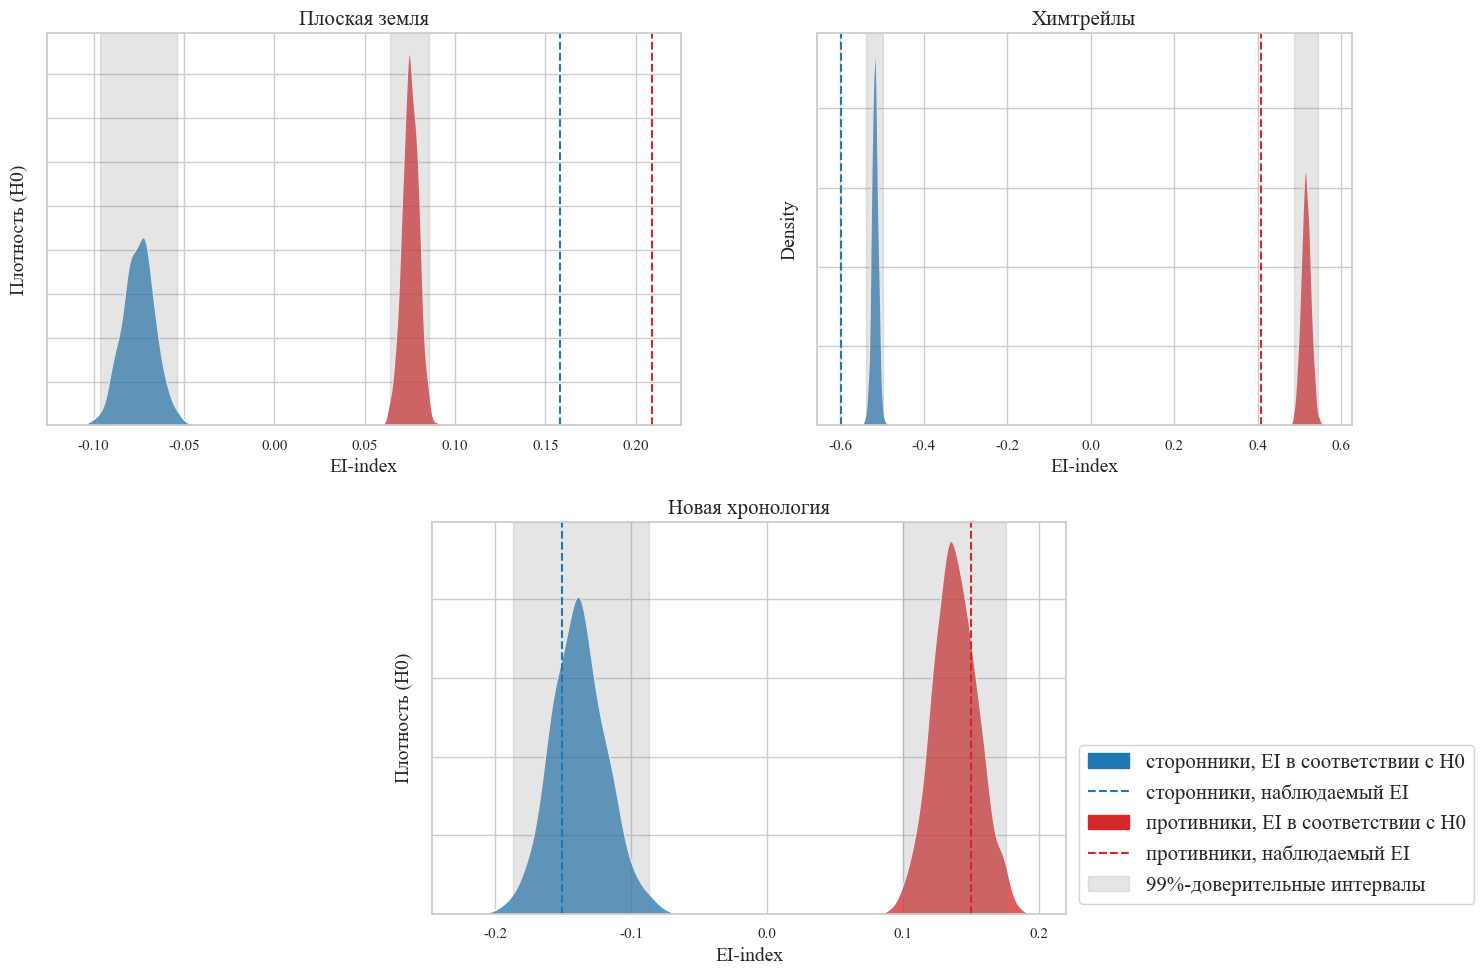

In [120]:
sns.set_theme(
    style="whitegrid",
    font_scale=1.25,                       # крупнее надписи по вкусу
    rc={
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "axes.unicode_minus": False,
    }
)
mpl.rcParams.update({                       # страховка
    "axes.titlesize":   15,
    "axes.labelsize":   14,
    "legend.fontsize":  13,
    "xtick.labelsize":  11,
    "ytick.labelsize":  11,
})

tnr = mpl.font_manager.FontProperties(family="Times New Roman")

# ── 2. разметка 2×4 остаётся как была ────────────────────────────────
fig = plt.figure(figsize=(15, 10))
gs  = gridspec.GridSpec(2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 0.6])

ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[1, 1:3])
legend_ax = fig.add_subplot(gs[1, 3])
legend_ax.axis("off")

axes         = [ax1, ax2, ax3]
theory_names = ["Плоская земля", "Химтрейлы", "Новая хронология"]

# ── 3. построение KDE, полос, линий ───────────────────────────────────
for i in range(3):
    sns.kdeplot([v[0] for v in ei_lists[i]], color=palette["поддерживает"],
                ax=axes[i], multiple="stack", legend=False)
    sns.kdeplot([v[1] for v in ei_lists[i]], color=palette["не поддерживает"],
                ax=axes[i], multiple="stack", legend=False)

    axes[i].axvline(ei_observed[i][0], color=palette["поддерживает"],
                    linestyle="--", linewidth=1.5)
    axes[i].axvline(ei_observed[i][1], color=palette["не поддерживает"],
                    linestyle="--", linewidth=1.5)

    axes[i].axvspan(*percentiles[i][0], color="gray", alpha=0.2,
                    label="центральные 98% по H0")
    axes[i].axvspan(*percentiles[i][1], color="gray", alpha=0.2,
                    label="центральные 98% по H0")

    axes[i].set_title(theory_names[i])
    axes[i].set_xlabel("EI-index")
    axes[i].set_yticklabels([])

ax1.set_ylabel("Плотность (H0)")
ax3.set_ylabel("Плотность (H0)")

# ── 4. легенда: те же handles, но шрифт TNR ──────────────────────────
handles = [
    mpatches.Patch(color=palette["поддерживает"],
                   label="сторонники, EI в соответствии с H0"),
    mlines.Line2D([], [], color=palette["поддерживает"], linestyle="--",
                  label="сторонники, наблюдаемый EI"),
    mpatches.Patch(color=palette["не поддерживает"],
                   label="противники, EI в соответствии с H0"),
    mlines.Line2D([], [], color=palette["не поддерживает"], linestyle="--",
                  label="противники, наблюдаемый EI"),
    mpatches.Patch(color="gray", alpha=0.2,
                   label="99%-доверительные интервалы")
]
leg = legend_ax.legend(handles=handles, loc="lower center", prop=tnr)

plt.tight_layout()
plt.show()

In [121]:
from collections import Counter
from collections import defaultdict

for G in [G_flat, G_chem, G_newchron]:
    stances = [data["stance"] for _, data in G.nodes(data=True)]
    stance_counts = Counter(stances)
    print("Количество вершин по stance:", stance_counts)
    
    total_degree = defaultdict(int)
    for node, data in G.nodes(data=True):
        stance = data["stance"]
        total_degree[stance] += G.degree(node)
    
    print("Суммарная степень по stance:", dict(total_degree), end="\n"*2)

Количество вершин по stance: Counter({'невозможно определить': 26541, 'не поддерживает': 14833, 'поддерживает': 11934})
Суммарная степень по stance: {'не поддерживает': 49219, 'поддерживает': 34913, 'невозможно определить': 31660}

Количество вершин по stance: Counter({'поддерживает': 6679, 'невозможно определить': 6537, 'не поддерживает': 2555})
Суммарная степень по stance: {'невозможно определить': 6270, 'поддерживает': 16009, 'не поддерживает': 7223}

Количество вершин по stance: Counter({'невозможно определить': 7178, 'не поддерживает': 2857, 'поддерживает': 2778})
Суммарная степень по stance: {'поддерживает': 5320, 'невозможно определить': 5361, 'не поддерживает': 5387}



In [237]:
import scipy.stats as stats

def edges_count(G, supporters, opposers):
    I_supporters = G.subgraph(supporters).number_of_edges()
    I_opposers = G.subgraph(opposers).number_of_edges()

    E_supporters = len([e for e in nx.edge_boundary(G, supporters, opposers)])
    E_opposers = len([e for e in nx.edge_boundary(G, opposers, supporters)])
    
    return (E_supporters, I_supporters), (E_opposers, I_opposers)


def edges_simulation(G, num_samples=100):
    in_degree_sequence = list(d for n, d in G.in_degree())
    out_degree_sequence = list(d for n, d in G.out_degree())
    supporters = [n for n, attr in G.nodes(data=True) if attr["stance"] == "поддерживает"]
    opposers = [n for n, attr in G.nodes(data=True) if attr["stance"] == "не поддерживает"]
    stances = nx.get_node_attributes(G, "stance")
    mapping = {i: n for i, n in enumerate(G.nodes)}

    result = list()

    for i in range(num_samples):
        G_sim = nx.directed_configuration_model(in_degree_sequence, out_degree_sequence)
        G_sim = nx.relabel_nodes(G_sim, mapping)
        nx.set_node_attributes(G_sim, stances, name="stance")
        result.append(edges_count(G_sim, supporters, opposers))
    
    return result

# params = stats.norm.fit([ei[0] for ei in ei_flat_list])
# D, p_value = stats.kstest([ei[0] for ei in ei_flat_list], "norm", args=params)
# print(f"Статистика теста: {D}, p-значение: {p_value}")

In [240]:
sim_edges_flat = edges_simulation(G_flat, 100)

In [302]:
import math

e_supporters = [ed[0][0] for ed in sim_edges_flat]

params = stats.norm.fit([e for e in e_supporters])
D, p_value = stats.kstest([e for e in e_supporters], "norm", args=params)
print(f"Статистика теста: {D}, p-значение: {p_value}")

defined_users = [n for n, attr in G_flat.nodes(data=True) if attr["stance"] != "невозможно определить"]
supporters = [n for n, attr in G_flat.nodes(data=True) if attr["stance"] == "поддерживает"]
opposers = [n for n, attr in G_flat.nodes(data=True) if attr["stance"] == "не поддерживает"]

G_flat_defined = G_flat.subgraph(defined_users)
ec = edges_count(G_flat_defined, supporters, opposers)
D_S_out, D_S_in, D_O_out, D_O_in = ec[0][0], ec[0][1], ec[1][0], ec[1][1]
N = sum([D_S_out, D_S_in, D_O_out, D_O_in])

mu = D_S_out * D_O_in / (D_O_in + D_S_in)
print(mu)

# sns.kdeplot(e_supporters)

Статистика теста: 0.06986846129160162, p-значение: 0.6868847633005787
3931.49182408721


In [283]:
def ei_simulation_correct(G, num_samples=100):
    in_degree_sequence = list(d for n, d in G.in_degree())
    out_degree_sequence = list(d for n, d in G.out_degree())
    supporters = [n for n, attr in G.nodes(data=True) if attr["stance"] == "поддерживает"]
    opposers = [n for n, attr in G.nodes(data=True) if attr["stance"] == "не поддерживает"]
    stances = nx.get_node_attributes(G, "stance")
    mapping = {i: n for i, n in enumerate(G.nodes)}

    ei_list = list()

    for i in range(num_samples):
        G_sim = nx.directed_configuration_model(in_degree_sequence, out_degree_sequence)
        G_sim = nx.relabel_nodes(G_sim, mapping) 
        nx.set_node_attributes(G_sim, stances, name="stance")
        G_sim.remove_edges_from(list(nx.selfloop_edges(G_sim)))
        G_sim = nx.DiGraph(G_sim)
        ei_list.append(nx_ei(G_sim, supporters, opposers))
    
    return ei_list